In [ ]:
# default_exp data.tsdataset

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import torch as t
from fastcore.foundation import patch
from torch.utils.data import Dataset, DataLoader

In [ ]:
#export
# TODO: resolver t_cols y X_cols duplicados t_cols se usa en dataloader X_cols para indexar con f_cols
#.      idea mantenemos solo X_cols y en el dataloader corregimos con 'y' y 'insample_mask' 
# TODO: paralelizar y mejorar _df_to_lists, probablemente Pool de multiprocessing
#.      si está balanceado el panel np reshape hace el truco <- pensar
# TODO: definir defaults para sample_mask, calculo de availabitly al interior con ds
class TimeSeriesDataset(Dataset):
    def __init__(self,
                 Y_df: pd.DataFrame,
                 X_df: pd.DataFrame=None,
                 S_df: pd.DataFrame=None,
                 mask_df: pd.DataFrame=None,
                 ds_in_test: int=0,
                 is_test: bool=False,
                 f_cols: list=None,
                 verbose: bool=False):
        """
        """
        assert type(Y_df) == pd.core.frame.DataFrame
        assert all([(col in Y_df) for col in ['unique_id', 'ds', 'y']])
        self.verbose = verbose

        if X_df is not None:
            assert type(X_df) == pd.core.frame.DataFrame
            assert all([(col in X_df) for col in ['unique_id', 'ds']])
            assert len(Y_df)==len(X_df), f'The dimensions of Y_df and X_df are not the same'

        if mask_df is not None:
            assert len(Y_df)==len(mask_df), f'The dimensions of Y_df and mask_df are not the same'
            assert all([(col in mask_df) for col in ['unique_id', 'ds', 'sample_mask']])
            if 'available_mask' not in mask_df.columns:
                self.verbose: print('Available mask not provided, defaulted with 1s.')
                mask_df['available_mask'] = 1
            assert np.sum(np.isnan(mask_df.available_mask.values))==0
            assert np.sum(np.isnan(mask_df.sample_mask.values))==0
        else:
            mask_df = self.get_default_mask_df(Y_df=Y_df, is_test=is_test,
                                               ds_in_test=ds_in_test)

        if self.verbose: print("Train Validation splits")
        mask_df['train_mask'] = mask_df['available_mask'] * mask_df['sample_mask']
        self.n_ds  = len(mask_df)
        self.n_avl = mask_df.available_mask.sum()        
        self.n_ins = mask_df.sample_mask.sum()
        self.n_out = len(mask_df)-mask_df.sample_mask.sum()

        avl_prc = np.round((100*self.n_avl)/self.n_ds,2)
        ins_prc = np.round((100*self.n_ins)/self.n_ds,2)
        out_prc = np.round((100*self.n_out)/self.n_ds,2)
        if self.verbose:
            print(mask_df.groupby(['unique_id', 'sample_mask']).agg({'ds': ['min', 'max']}))
            print(f'Total data \t\t\t{self.n_ds} time stamps')
            print(f'Available percentage={avl_prc}, \t{self.n_avl} time stamps')
            print(f'Insample  percentage={ins_prc}, \t{self.n_ins} time stamps')
            print(f'Outsample percentage={out_prc}, \t{self.n_out} time stamps')
            print('\n')

        ts_data, s_data, self.meta_data, self.t_cols, self.X_cols \
                         = self._df_to_lists(Y_df=Y_df, S_df=S_df, X_df=X_df, mask_df=mask_df)

        # Dataset attributes
        self.n_series   = len(ts_data)
        self.max_len    = max([len(ts['y']) for ts in ts_data])
        self.n_channels = len(self.t_cols) # y, X_cols, insample_mask and outsample_mask
        self.frequency  = pd.infer_freq(Y_df.head()['ds']) #TODO: improve, can die with head
        self.f_cols     = f_cols

        # Number of X and S features
        self.n_x = 0 if X_df is None else len(self.X_cols)
        self.n_s = 0 if S_df is None else S_df.shape[1]-1 # -1 for unique_id

        # print('Creating ts tensor ...')
        # Balances panel and creates 
        # numpy  s_matrix of shape (n_series, n_s)
        # numpy ts_tensor of shape (n_series, n_channels, max_len) n_channels = y + X_cols + masks
        self.ts_tensor, self.s_matrix, self.len_series = self._create_tensor(ts_data, s_data)

    def get_default_mask_df(self, Y_df, ds_in_test, is_test):
        # Creates outsample_mask
        # train 1 validation 0
        last_df = Y_df.copy()[['unique_id', 'ds']]
        last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
        last_df.reset_index(drop=True, inplace=True)

        last_df = last_df.groupby('unique_id').head(ds_in_test)
        last_df['sample_mask'] = 0

        last_df = last_df[['unique_id', 'ds', 'sample_mask']]

        mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
        mask_df['sample_mask'] = mask_df['sample_mask'].fillna(1)

        mask_df = mask_df[['unique_id', 'ds', 'sample_mask']]
        mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
        mask_df['available_mask'] = 1

        assert len(mask_df)==len(Y_df), \
            f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'
        
        if is_test:
            mask_df['sample_mask'] = 1 - mask_df['sample_mask']

        return mask_df

    def _df_to_lists(self, Y_df, S_df, X_df, mask_df):
        """ TODO: Comment on unbalanced panels
        """
        unique_ids = Y_df['unique_id'].unique()

        if X_df is not None:
            X_cols = [col for col in X_df.columns if col not in ['unique_id','ds']]
        else:
            X_cols = []

        if S_df is not None:
            S_cols = [col for col in S_df.columns if col not in ['unique_id']]
        else:
            S_cols = []

        ts_data = []
        s_data = []
        meta_data = []
        for i, u_id in enumerate(unique_ids):
            #top_row    = np.asscalar(Y_df['unique_id'].searchsorted(u_id, 'left'))
            #bottom_row = np.asscalar(Y_df['unique_id'].searchsorted(u_id, 'right'))
            top_row    = Y_df['unique_id'].searchsorted(u_id, 'left').item()
            bottom_row = Y_df['unique_id'].searchsorted(u_id, 'right').item()
            
            # Y values
            y_true = Y_df[top_row:bottom_row]['y'].values
            ts_data_i = {'y': y_true}
            
            # X values
            for X_col in X_cols:
                serie =  X_df[top_row:bottom_row][X_col].values
                ts_data_i[X_col] = serie

            # Mask values
            available_mask = mask_df[top_row:bottom_row]['available_mask'].values
            sample_mask = mask_df[top_row:bottom_row]['sample_mask'].values            
            ts_data_i['available_mask'] = available_mask
            ts_data_i['sample_mask']  = sample_mask
            ts_data.append(ts_data_i)

            # S values
            s_data_i = defaultdict(list)
            for S_col in S_cols:
                s_data_i[S_col] = S_df.loc[S_df['unique_id']==u_id, S_col].values
            s_data.append(s_data_i)

            # Metadata
            last_ds_i  = Y_df[top_row:bottom_row]['ds']
            meta_data_i = {'unique_id': u_id,
                           'last_ds': last_ds_i}
            meta_data.append(meta_data_i)

        t_cols = ['y'] + X_cols + ['available_mask', 'sample_mask']

        return ts_data, s_data, meta_data, t_cols, X_cols

    def _create_tensor(self, ts_data, s_data):
        """
        s_matrix of shape (n_series, n_s)
        ts_tensor of shape (n_series, n_channels, max_len) n_channels = y + X_cols + masks
        """
        s_matrix  = np.zeros((self.n_series, self.n_s))
        ts_tensor = np.zeros((self.n_series, self.n_channels, self.max_len))

        len_series = []
        for idx in range(self.n_series):
            # Left padded time series tensor
            # TODO: Maybe we can place according to ds
            ts_idx = np.array(list(ts_data[idx].values()))

            ts_tensor[idx, :, -ts_idx.shape[1]:] = ts_idx
            s_matrix[idx, :] = list(s_data[idx].values())
            len_series.append(ts_idx.shape[1])
        
        return ts_tensor, s_matrix, np.array(len_series)

    def get_meta_data_col(self, col):
        """
        """
        col_values = [x[col] for x in self.meta_data]
        return col_values

    def get_filtered_ts_tensor(self, offset, output_size, window_sampling_limit, ts_idxs=None):
        """
        Esto te da todo lo que tenga el tensor, el futuro incluido esto orque se usa exogenoas del futuro
        La mascara se hace despues
        """
        last_outsample_ds = self.max_len - offset + output_size
        first_ds = max(last_outsample_ds - window_sampling_limit - output_size, 0)
        if ts_idxs is None:
            filtered_ts_tensor = self.ts_tensor[:, :, first_ds:last_outsample_ds]
        else:
            filtered_ts_tensor = self.ts_tensor[ts_idxs, :, first_ds:last_outsample_ds]
        right_padding = max(last_outsample_ds - self.max_len, 0) #To padd with zeros if there is "nothing" to the right

        #assert np.sum(np.isnan(filtered_ts_tensor))<1.0, \
        #   f'The balanced balanced filtered_tensor has {np.sum(np.isnan(filtered_ts_tensor))} nan values'
        
        return filtered_ts_tensor, right_padding #ANTES, ts_train_mask

    def get_f_idxs(self, cols):
        # Check if cols are available f_cols and return the idxs
        assert all(col in self.f_cols for col in cols), f'Some variables in {cols} are not available in f_cols.'
        f_idxs = [self.X_cols.index(col) for col in cols]
        return f_idxs


# MASK example and test

In [ ]:
#export
def get_default_mask_df(Y_df, ds_in_test, is_test):
    # Creates outsample_mask
    # train 1 validation 0
    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(ds_in_test)
    last_df['sample_mask'] = 0

    last_df = last_df[['unique_id', 'ds', 'sample_mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['sample_mask'] = mask_df['sample_mask'].fillna(1)

    mask_df = mask_df[['unique_id', 'ds', 'sample_mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    mask_df['available_mask'] = 1

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    if is_test:
        mask_df['sample_mask'] = 1 - mask_df['sample_mask']

    return mask_df

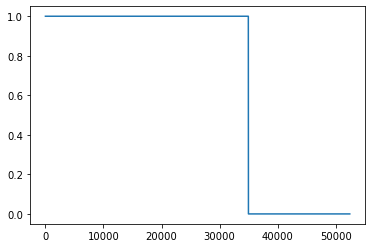

In [ ]:
import matplotlib.pyplot as plt
from nixtla.data.datasets.epf import EPF, EPFInfo

args = pd.Series({'dataset': ['NP']})

Y_df, Xt_df, S_df = EPF.load_groups(directory='../data', groups=args.dataset)

mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=728*24, is_test=False)

plt.plot(mask_df.sample_mask.values)

In [ ]:
dataset = TimeSeriesDataset(Y_df=Y_df, S_df=S_df, X_df=Xt_df, mask_df=mask_df)

/zfsauton2/home/kdgutier/anaconda3/envs/nixtla/lib/python3.7/site-packages/ipykernel_launcher.py:176: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


In [ ]:
dataset.t_cols

['y',
 'Exogenous1',
 'Exogenous2',
 'week_day',
 'day_0',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'available_mask',
 'sample_mask']

In [ ]:
print(dataset.ts_tensor[0, dataset.t_cols.index('y'), :])

[31.05 30.47 28.92 ... 49.09 49.02 48.1 ]


In [ ]:
print("dataset.ts_tensor.shape", dataset.ts_tensor.shape)

dataset.ts_tensor.shape (1, 13, 52416)


In [ ]:
filtered, right_padding = dataset.get_filtered_ts_tensor(offset=10, output_size=12, window_sampling_limit=36)